In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

### 1. op/qlearning – Q-learning is off-policy.

Q-learning is considered off-policy because it learns the value of the optimal policy independently of the agent's actions. That is, the update rule uses the maximum estimated Q-value of the next state (i.e., assumes greedy behavior in the future) regardless of what action the agent actually takes during exploration.

\begin{equation*}
    Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
\end{equation*}

This contrasts with on-policy methods like SARSA, which update based on the action actually taken.

### 2. td/sarsa/qlearning – Difference between SARSA and Q-learning.
Is Q-learning the same algorithm as SARSA with greedy action selection? If not, why?

No, Q-learning is not the same as SARSA, even with greedy action selection. While greedy SARSA also chooses the action $a' = \argmax_{a'} Q(s', a')$ it uses the actual action taken during exploration, including any stochasticity. This makes SARSA an on-policy method.In contrast, Q-learning always uses $\max_{a'}Q(s', a')$ regardless of the action taken — making it fundamentally off-policy.



### 3. td/tab/grad – Tabular updates as gradient descent.

In order to (locally) minimize a function $f: \mathbb{R}^d \mapsto \mathbb{R}$, we can use the gradient-descent iteration:

\begin{equation*}
    x_{t + 1} := x_t - \alpha_t \nabla f(x_t)
\end{equation*}

Find a function $f$ whose gradient-descent iteration is the general tabular update formula.

\begin{equation*}
    V(S_t) := V(S_t) + \alpha_t (Y_t - V(S_t))
\end{equation*}

while assuming that the gradient of the target $Y_t$ vanishes.

Let $x = V(S_t)$ and let:

\begin{equation*}
    f(x) = \frac{1}{2}(Y_t - x)^2
\end{equation*}

Then we have:

\begin{equation*}
    \nabla f(x) = - (Y_t - x) \implies x_{t + 1} = x + \alpha_t (Y_t - x)
\end{equation*}

check for exam vector case same as discretized scalar - grad of v hat is x(s) where x(s) i is characteristic function of the states 1 s=i 0 s not i

### 4. grad/huber – Huber loss and gradient descent.
Here, the 2-norm and the 1-norm are combined into a loss function. The Huber loss $L_\delta : \mathbb{R} \mapsto \mathbb{R}_0^+ $ is defined as 
\begin{equation*}
L_\delta(a) = \begin{cases}
    \frac{1}{2} a^2  & |a| \leq \delta, \\
    \lambda|a| + \mu & |a| > \delta, 
    \end{cases}
\end{equation*}

where $\delta \in \mathbb{R}_0^+$ is a constant that defines the transition from quadratic to linear behavior.

(a) Determine the constants $\lambda, \mu \in \mathbb{R}$ such that $L_\delta$ is as smooth as possible.

(b) For
\begin{equation*}
    f(w_t) := L_\delta (Y_t - \hat{v}(s, w_t))
\end{equation*}
in Exercise TDTABGRAD, what is resulting tabular update formula?

(c) For more than one sample, we can consider the loss $\sum_{i = 1}^d L_\delta(a_i)$ of a vector $a \in \mathbb{R}^d$. What are its advantages compared to the 2-norm and the 1-norm when used in gradient descent?


(a) We want $L_\delta(a)$ to be $C^1$ smooth: both value and derivative must be continuous at $|a| = \delta$. Matching function values we have:
\begin{equation*}
    \frac{1}{2}\delta^2 = \lambda\delta + \mu
\end{equation*}
Matching derivatives at $a = \delta$ we have from one side:
\begin{equation*}
    \frac{d}{da} (\frac{1}{2} a^2) = a = \delta
\end{equation*}
From the other side:
\begin{equation*}
    \frac{d}{da}(\lambda |a| + \mu) = \lambda sign(a) = \lambda,
\end{equation*}
therefore we have $\lambda = \delta$.

Now, going back to first equation we have:
\begin{equation*}
    \frac{1}{2} \delta^2 = \delta^2 + \mu,
\end{equation*}
from which we get $\mu = - \frac{1}{2} \delta^2$.

(b) We have $a = Y_t - V(S_t)$ (with assumption that $V(S_t) = \hat{v}(s, w_t)$) so Huber loss takes this form:

\begin{equation*}
    L_\delta(Y_t - V(S_t)) = \begin{cases}
    \frac{1}{2} (Y_t - V(S_t))^2, & |Y_t - V(S_t)| \leq \delta \\
    \delta |Y_t - V(S_t)| - \frac{1}{2}\delta^2  & |Y_t - V(S_t)| > \delta
    \end{cases}
\end{equation*}

So if we want to find resulting tabular update, we need to find derivatives in $L_\delta(Y_t - V(S_t))$ by $V(S_t)$ (because that's what we update):
\begin{equation*}
    V(S_t) = \begin{cases}
    V(S_t) + \alpha_t (Y_t - V(S_t)), & |Y_t - V(S_t)| \leq \delta \\
    V(S_t) + \alpha_t \delta sign(Y_t - V(S_t))  & |Y_t - V(S_t)| > \delta
    \end{cases}
\end{equation*}

(c) Advantages of Huber over 2-norm and 1-norm (it combines pros of both):

- Less sensitive to outliers (robust like 1-norm when $|a| > \delta$)
- Smooth like 2-norm when $|a| \leq \delta$ (avoid problem with non-differentiability around 0 with 1-norm)
- Gradient is bounded, avoiding exploding gradients

### 5. impl – SARSA.
Implement SARSA and apply it to (at least) one of the environments you have implemented.

In [4]:
class CliffWalking:
    def __init__(self, width=12, height=4):
        self.height = height
        self.width = width
        self.start = (height - 1, 0)
        self.goal = (height - 1, width - 1)
        self.cliff = [(height - 1, i) for i in range(1, width - 1)]  # the cliff region
        self.actions = ['up', 'down', 'left', 'right'] 
        self.state = self.start # current state
        self.rewards = -1  # constant reward of -1 for each step
        self.state_values = np.zeros((width, height))
        self.action_space = len(self.actions)

    def reset(self):
        self.state = self.start
        return self.state

    def is_terminal(self, state):
        return state == self.goal

    def step(self, action): # make one step in the environment S_t, A_t -> R_t, S'_t
        if self.state in self.cliff:
            return self.start, -100  # if you step on a cliff -> go back to the start with -100 reward 

        # calculate next position based on current state and action
        x, y = self.state
        if action == 'up':
            x = max(x - 1, 0)
        elif action == 'down':
            x = min(x + 1, self.height - 1)
        elif action == 'left':
            y = max(y - 1, 0)
        elif action == 'right':
            y = min(y + 1, self.width - 1)

        next_state = (x, y)
        # check if the next state is the cliff
        if next_state in self.cliff:
            self.reset()
            return self.start, -100

        self.state = next_state
        return next_state, self.rewards # const -1

In [5]:
def run_episode(gridworld, max_trials):
    state = gridworld.reset() # come to the start
    total_reward = 0
    steps = []
    while not gridworld.is_terminal(state): # as long as the goal isn't reached
        action = np.random.choice(gridworld.actions)  # random policy for demonstration
        next_state, reward = gridworld.step(action)
        total_reward += reward
        steps.append((state, action))
        state = next_state
        if state == gridworld.start and reward == -100:
            print("Fell into the cliff, back to start. Current reward: ", total_reward)
        if gridworld.is_terminal(state):
            print("Reached goal, episode ends. Final reward: ", total_reward)
            break
        # not cliff, not goal -> just continue moving
    return total_reward, steps

cliff_grid_world = CliffWalking(width=12, height=4)
episode_reward, steps = run_episode(cliff_grid_world, max_trials=20)

Fell into the cliff, back to start. Current reward:  -103
Fell into the cliff, back to start. Current reward:  -206
Fell into the cliff, back to start. Current reward:  -312
Fell into the cliff, back to start. Current reward:  -431
Fell into the cliff, back to start. Current reward:  -532
Fell into the cliff, back to start. Current reward:  -632
Fell into the cliff, back to start. Current reward:  -732
Fell into the cliff, back to start. Current reward:  -836
Fell into the cliff, back to start. Current reward:  -942
Fell into the cliff, back to start. Current reward:  -1044
Fell into the cliff, back to start. Current reward:  -1146
Fell into the cliff, back to start. Current reward:  -1248
Fell into the cliff, back to start. Current reward:  -1355
Fell into the cliff, back to start. Current reward:  -1473
Fell into the cliff, back to start. Current reward:  -1573
Fell into the cliff, back to start. Current reward:  -1673
Fell into the cliff, back to start. Current reward:  -1773
Fell i

In [12]:
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state])) # take non-greedy (random) action
    else:
        # take a greedy action, breaking ties randomly
        max_indices = np.flatnonzero(Q[state] == np.max(Q[state]))
        return np.random.choice(max_indices)

In [ ]:
def sarsa(gridworld, num_episodes, alpha=0.1, gamma=1, epsilon=0.1):
    Q = np.zeros((gridworld.height, gridworld.width, gridworld.action_space))
    episode_rewards = [] 
    for episode_i in range(num_episodes):
        # start a new episode
        state = gridworld.reset()
        total_reward = 0
        action = epsilon_greedy_policy(Q, state, epsilon) # A
        while not gridworld.is_terminal(state):  # loop for each step of episode
            next_state, reward = gridworld.step(gridworld.actions[action]) # S, A -> S', R
            next_action = epsilon_greedy_policy(Q, next_state, epsilon) # A'
            total_reward += reward
            # update formula
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            total_reward += reward

        episode_rewards.append(total_reward)
                                                       
    return Q, episode_rewards

In [14]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q_values, _ = sarsa(cliff_grid_world, num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.1)

In [15]:
def print_optimal_policy(Q, gridworld):
    direction_map = {0: '↑ ', 1: '↓ ', 2: '← ', 3: '→ '}
    optimal_policy = np.argmax(Q, axis=2) # find the optimal policy
    for i in range(gridworld.height):
        row = ""
        for j in range(gridworld.width):
            if (i, j) == gridworld.start:
                row += "S   "
            elif (i, j) == gridworld.goal:
                row += "G   "
            elif (i, j) in gridworld.cliff:
                row += "X   "
            else:
                row += direction_map[optimal_policy[i][j]] + "  "
        print(row)

In [20]:
print_optimal_policy(Q_values, cliff_grid_world)

→   →   →   →   →   →   →   →   →   →   →   ↓   
→   →   →   →   →   →   →   →   →   →   →   ↓   
↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


### 6. impl – Expected SARSA.
Implement expected SARSA and apply it to (at least) one of the environments you have implemented.

In [21]:
def expected_sarsa(gridworld, num_episodes, alpha=0.1, gamma=1, epsilon=0.1):
    Q = np.zeros(shape=(gridworld.height, gridworld.width, gridworld.action_space))
    episode_rewards = []
    for episode_i in range(num_episodes):
        # start a new episode
        state = gridworld.reset()
        total_reward = 0
        while not gridworld.is_terminal(state): # loop for each step of episode
            action = epsilon_greedy_policy(Q, state, epsilon) # A
            next_state, reward = gridworld.step(gridworld.actions[action]) # S, A -> S', R
            total_reward += reward
            # compute expected Q value (over (S', A') pairs)
            expected_q = 0
            for a in range(gridworld.action_space): # go through all posible A'
                if a != np.argmax(Q[next_state]):  # if not the greedy action
                    action_prob = epsilon / gridworld.action_space
                else:
                    action_prob = 1 - epsilon + epsilon / gridworld.action_space
                    
                expected_q += action_prob * Q[next_state[0], next_state[1], a]

            # update formula
            Q[state][action] += alpha * (reward + gamma * expected_q - Q[state][action])
            state = next_state

        episode_rewards.append(total_reward)
        # print(f"Episode: {episode_i}, finished after: {time.time() - start_time}")
        
    return Q, episode_rewards


In [22]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q_values, _ = expected_sarsa(cliff_grid_world, num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.2)

In [23]:
print_optimal_policy(Q_values, cliff_grid_world)

→   →   →   →   →   →   →   →   →   →   →   ↓   
↑   →   →   →   →   →   →   →   →   →   →   ↓   
↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   ↑   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


### 7. impl – Q-learning. 
Implement Q-learning and apply it to (at least) one of the environments you have implemented.

In [24]:
def q_learning(gridworld, num_episodes, alpha=0.1, gamma=1, epsilon=0.1):
    Q = np.zeros(shape=(gridworld.height, gridworld.width, len(gridworld.actions)))
    episode_rewards = []
    for episode_i in range(num_episodes):
        # start a new episode
        state = gridworld.reset()
        total_reward = 0
        while not gridworld.is_terminal(state): # loop for each step of episode
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward = gridworld.step(gridworld.actions[action]) # S, A -> S', R
            total_reward += reward
            best_next_action = np.argmax(Q[next_state])  # find the best next action using current Q estimate (optimistic approach)
            # update formula
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state
        episode_rewards.append(total_reward)
    return Q, episode_rewards

In [25]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q_values, rewards = q_learning(cliff_grid_world, num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.1)

In [26]:
print_optimal_policy(Q_values, cliff_grid_world)

→   →   →   →   →   →   →   →   →   →   ↓   ↓   
→   ↓   →   →   →   ↓   ↓   ↓   →   ↓   ↓   ↓   
→   →   →   →   →   →   →   →   →   →   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


### 8. impl – Double Q-learning.
Implement double Q-learning and apply it to (at least) one of the environments you have implemented.

In [27]:
def epsilon_greedy_policy_double(Q_1, Q_2, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(range(len(Q_1[state]))) # take non-greedy (random) action
    else:
        # take a greedy action (based on "combined" value function e.g. sum(Q_1 + Q_2), avg(Q_1 + Q_2)), breaking ties randomly
        max_indices = np.flatnonzero((Q_1[state] + Q_2[state]) == np.max(Q_1[state] + Q_2[state]))
        return np.random.choice(max_indices)

In [28]:
def double_q_learning(gridworld, num_episodes, alpha=0.1, gamma=1, epsilon=0.1):
    Q_1 = np.zeros(shape=(gridworld.height, gridworld.width, gridworld.action_space))
    Q_2 = np.zeros(shape=(gridworld.height, gridworld.width, gridworld.action_space))
    episode_rewards = [] # for plotting for task 4
    for episode_i in range(num_episodes):
        # start a new episode
        state = gridworld.reset()
        total_reward = 0
        while not gridworld.is_terminal(state): # loop for each step of episode
            action = epsilon_greedy_policy_double(Q_1, Q_2, state, epsilon) # A
            next_state, reward = gridworld.step(gridworld.actions[action]) # S, A -> S', R
            total_reward += reward
            if np.random.rand() < 0.5: # flip a coin
                # updating Q_1
                best_next_action = np.argmax(Q_1[next_state]) # A'
                Q_1[state][action] += alpha * (reward + gamma * Q_2[next_state][best_next_action] - Q_1[state][action])
            else:
                # updating Q_2
                best_next_action = np.argmax(Q_2[next_state]) # A'
                Q_2[state][action] += alpha * (reward + gamma * Q_1[next_state][best_next_action] - Q_2[state][action])

            state = next_state
        episode_rewards.append(total_reward)
        
    return Q_1, Q_2, episode_rewards

In [29]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q1_values, Q2_values, _ = double_q_learning(cliff_grid_world, num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.2)

In [33]:
# overall (optimal) policy: combination of Q_1, Q_2
Q_optimal = Q1_values + Q2_values 
print_optimal_policy(Q_optimal, cliff_grid_world)

↓   ↓   ↓   ↓   →   ↓   ↓   ↓   ↓   →   →   ↓   
↓   ↓   ↓   ↓   →   ↓   ↓   →   ↓   ↓   →   ↓   
→   →   →   →   →   →   →   →   →   →   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


### 9. td/tab/speedyqlearning – Tabular Speedy Q-learning (programming).
In [2], the Q-learning variant
\begin{align*}
    Q_{t + 1}(s, a) &:= Q_t(s, a) + \alpha_t(\mathcal{B}_t Q_{t - 1}(s, a) - Q_t(s, a)) + (1 - \alpha_t)(\mathcal{B}_t Q_t(s, a) - \mathcal{B}_t Q_{t - 1}(s, a)), \\
    \alpha_t &:= \frac{1}{t + 1}, \\
    \mathcal{B}_t Q_t(s, a) &:= R_{t + 1} + \gamma \max_a Q_t(S_{t + 1}, a), 
\end{align*}

was defined and called Speedy Q-learning. (Here $\mathcal{B}_t$ is the (usual) empirical Bellman operator. Note that it is applied to $Q_t(s, a)$ and to $Q_{t - 1}(s, a)$. Implement Speedy Q-learning for estimating $q_*$ and use it to estimate $\pi_*$ for cliff walking in Exercise gw/cliff.
Compare Q-learning and Speedy Q-learning with the learning rate defined above and with adjusted learning rates. Which algorithm converges faster? What is influence of learning rate?

In [ ]:
def speedy_q_learning(grid_world, num_episodes, gamma=1, epsilon=0.1):
    Q = np.zeros(shape=(grid_world.height, grid_world.width, len(grid_world.actions))) # t
    Q_old = np.zeros_like(Q) # t-1 (previous time step)
    episode_rewards = []

    for episode_i in range(num_episodes):
        # start a new episode
        state = grid_world.reset()
        total_reward = 0  # reset total reward for the new episode
        step = 0
        while not grid_world.is_terminal(state): # loop for each step of episode
            alpha = 1 / (step + 1) # dynamic learning rate (decreasing as time porgresses) -> bigger steps at the beginning, smaller at the end
            action = epsilon_greedy_policy(Q, state, epsilon) # A
            next_state, reward = grid_world.step(grid_world.actions[action]) # S, A -> S', R
            total_reward += reward

            # find the best next action using current and previous Q tables (Q_t and Q_t-1)
            best_next_action = np.argmax(Q[next_state])
            best_next_action_old = np.argmax(Q_old[next_state])

            # update formula
            Q_old[state][action] = Q[state][action]  # update old Q, with current
            Q[state][action] += alpha * (reward + gamma * Q_old[next_state][best_next_action_old] - Q[state][action])
            # alpha shouldn't multiply here again :( but didn't work well without it
            Q[state][action] += alpha * ((1 - alpha) * (reward + gamma * Q[next_state][best_next_action] - reward - gamma * Q_old[next_state][best_next_action_old]))

            state = next_state
            step += 1

        episode_rewards.append(total_reward)  # store the accumulated reward for the episode, reason: plotting
    return Q, episode_rewards

In [36]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q_values_speedy, rewards = speedy_q_learning(cliff_grid_world, num_episodes=5000, gamma=1, epsilon=0.2)

In [38]:
print_optimal_policy(Q_values_speedy, cliff_grid_world)

→   →   ←   →   →   →   →   →   →   ↓   ↓   ↓   
↓   →   →   →   →   →   →   →   →   →   ↓   ↓   
→   →   →   →   →   →   →   →   →   →   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


In [40]:
cliff_grid_world = CliffWalking(width=12, height=4)
Q_values, rewards = q_learning(cliff_grid_world, num_episodes=5000, alpha=0.1, gamma=1, epsilon=0.1)

In [44]:
print_optimal_policy(Q_values, cliff_grid_world)

↑   →   →   →   →   →   →   ↓   →   →   ↓   ↓   
↓   ↓   →   ↓   →   →   →   ↓   ↓   ↓   →   ↓   
→   →   →   →   →   →   →   →   →   →   →   ↓   
S   X   X   X   X   X   X   X   X   X   X   G   


In [45]:
num_episodes = 5000
alpha = 0.2
gamma = 1
epsilon = 0.2

grid_world = CliffWalking(width=12, height=4)

# 2 algorithms
_, rewards_q_learning = q_learning(grid_world, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
_, rewards_speedy_q_learning = speedy_q_learning(grid_world, num_episodes=num_episodes, gamma=gamma)

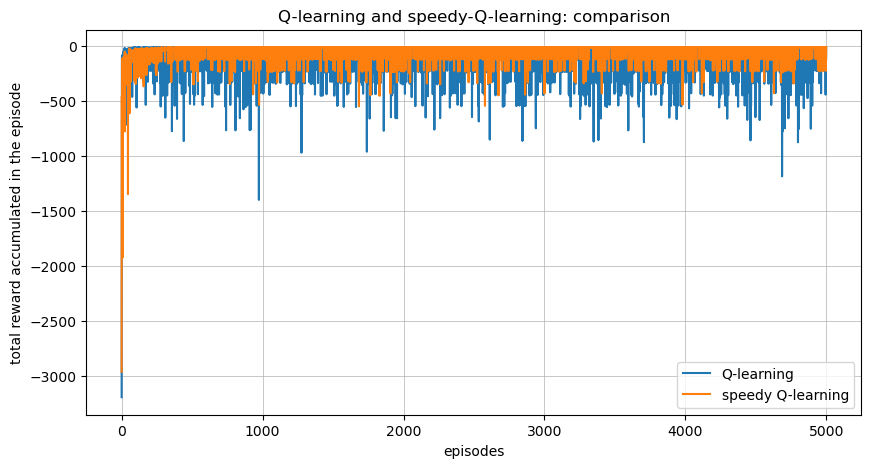

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(rewards_q_learning, label='Q-learning')
plt.plot(rewards_speedy_q_learning, label='speedy Q-learning')
plt.xlabel('episodes')
plt.ylabel('total reward accumulated in the episode')
plt.title('Q-learning and speedy-Q-learning: comparison')
plt.legend()
plt.grid(linewidth=0.5)
plt.show()